# Predicting the Newsletter Subscription status of Minecraft Players
!!! <br>
A data science project submitted in partial fulfillment of the Requirements for the DSCI 100 Introduction to Data Science Course at the University of British Columbia <br>
Jun 23, 2025

## Introduction

!!! Re-phrase

A research group in Computer Science at UBC, The Pacific Laboratory for Artificial Intelligence (PLAI), led by Frank Wood, is collecting data on players of MineCraft. They have set up a MineCraft server, and players' information and actions are recorded.

Player types are by experience: Veteran, Pro, Regular, Amateur

In order to target their recruitment efforts, they would like to know 
**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**



This project will explore some aspects of the above question, specifically:
compare the predictive power of age, total hours, total number of sessions and max duration for whether a player ia subsribed to the newsleetter.

How do characteristics like age, gender etc. differ between various player types (exprience levels).


Specifically, it will look at 


!!! In your project, you will select one of these broad questions and use it to formulate a specific question using some of the variables in the dataset.  Your project should answer your specific question. 




## Methods & Results
1. First explore the player characteristics
2. Explore the behavior
2. Based on initial exploration, select which factors to use in the model for predicting subscription or not
3. Build model, predict
4. Assess prediction

In [1]:
# !!! Be sure to load only the needed ones

library(tidyverse)
library(repr)
library(tidymodels)

# set seed once for reproducibility
set.seed(2473)

# Only display top 6 rows of data frames
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 1. Read the data

In [2]:
players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")

players_data
sessions_data

# Check for Missing NA values

any(is.na(players_data)) #TRUE - there are two observations without age
any(is.na(sessions_data)) #TRUE - there are two observations without end time

# Since there are only two observations wihtout end time, and two observations without age,
# we will remove them to not cause issues in downstream analyses
sessions_data_NA_omitted <- na.omit(sessions_data)
players_data_NA_omitted <- na.omit(players_data)

# check if there are any start and end dates that aren't the same for a single session
sessions_data_sep_date_time <- sessions_data |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ")

sessions_data_diff_start_end_date <- sessions_data_sep_date_time |>
    filter(start_date != end_date)

sessions_data_diff_start_end_date

# Yes, there are 92 cases of sessions spanning 2 (or more) days

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
⋮   ⋮            ⋮         ⋮                 ⋮  
194 0.0          Dylan     Prefer not to say 17 
195 2.3          Harlow    Male              17 
196 0.2          Ahmed     Other             NA

hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3    f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮    ⋮                                                               
1533 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1534 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1535 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time       end_time         original_start_time original_end_time
1    30/06/2024 18:12 30/06/2024 18:24 1.71977e+12         1.71977e+12      
2    17/06/2024 23:33 17/06/2024 23:46 1.71867e+12         1.71867e+12      
3    25/07/2024 17:34 25/07/2024 17:57 1.72193e+12         1.72193e+12      
⋮    ⋮                ⋮                ⋮                   ⋮                
1533 28/07/2024 15:36 28/07/2024 15:57 1.72218e+12         1.72218e+12      
1534 25/07/2024 06:15 25/07/2024 06:22 1.72189e+12         1.72189e+12      
1535 20/05/2024 02:26 20/05/2024 02:45 1.71617e+12         1.71617e+12

[1] TRUE

[1] TRUE

hashedEmail                                                      start_date
1  f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc 12/05/2024
2  bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf 29/06/2024
3  f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc 27/07/2024
⋮  ⋮                                                                ⋮         
90 bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf 03/08/2024
91 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319 18/08/2024
92 b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319 28/08/2024
   start_time end_date   end_time original_start_time original_end_time
1  23:23      13/05/2024 00:14    1.71556e+12         1.71556e+12      
2  21:26      30/06/2024 00:00    1.71970e+12         1.71971e+12      
3  23:30      28/07/2024 00:23    1.72212e+12         1.72213e+12      
⋮  ⋮          ⋮          ⋮        ⋮                   ⋮                
90 22:33      04/08/2024 00:51    1.72272e+12         1.72273e+12      
91 21:54      19/08/2024 02:09    1.72402e+12         1.72403e+12      
92 23:31      29/08/2024 00:15    1.72489e+12         1.72489e+12

Clean up the data:

In [3]:
## Convert categorical variables to factor, esp needed for subscribe, which we are interested in classifying by:
players_data_clean <- players_data_NA_omitted |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(experience = as_factor(experience)) |>
    mutate(gender = as_factor(gender)) #|>
    #mutate(subscribe = fct_recode(subscribe, "TRUE" = "subscribed", "FALSE" = "Not subscribed"))   # !!! can't get to work

sessions_data_clean <- sessions_data_NA_omitted |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
    select(hashedEmail:end_time) # Since we will not be using the original times

# View clean data and dimensions:
players_data_clean
dim(players_data_clean)

sessions_data_clean
dim(sessions_data)

experience subscribe
1   Pro        TRUE     
2   Veteran    TRUE     
3   Veteran    FALSE    
⋮   ⋮          ⋮        
192 Veteran    FALSE    
193 Amateur    FALSE    
194 Amateur    FALSE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
192 71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd
193 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
194 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
⋮   ⋮            ⋮         ⋮                 ⋮  
192 0.3          Pascal    Male              22 
193 0.0          Dylan     Prefer not to say 17 
194 2.3          Harlow    Male              17

[1] 194   7

hashedEmail                                                     
1    bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
2    36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
3    f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮    ⋮                                                               
1531 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1532 fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
1533 36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
     start_time          end_time           
1    2024-06-30 18:12:00 2024-06-30 18:24:00
2    2024-06-17 23:33:00 2024-06-17 23:46:00
3    2024-07-25 17:34:00 2024-07-25 17:57:00
⋮    ⋮                   ⋮                  
1531 2024-07-28 15:36:00 2024-07-28 15:57:00
1532 2024-07-25 06:15:00 2024-07-25 06:22:00
1533 2024-05-20 02:26:00 2024-05-20 02:45:00

[1] 1535    5

!!! Next, scatterplot of Age vs Total time played with points colored by subscription status or not to see if there are any visible patterns.

percent_subscribed
1 73.19588

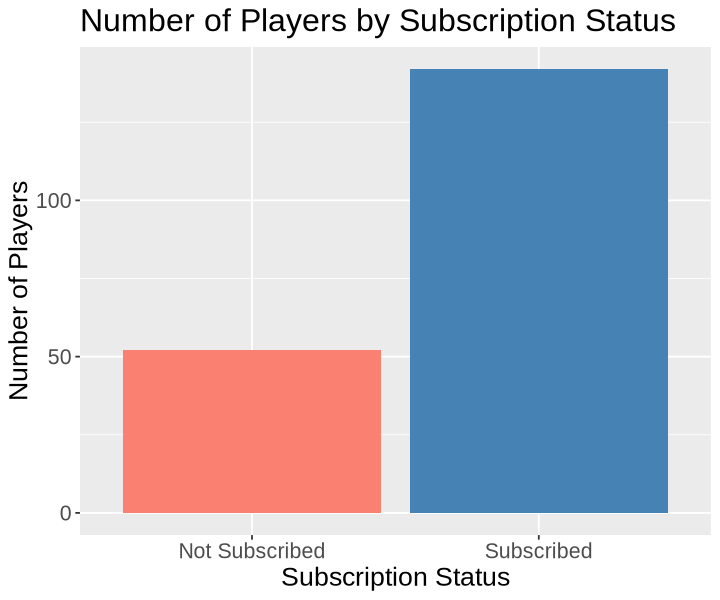

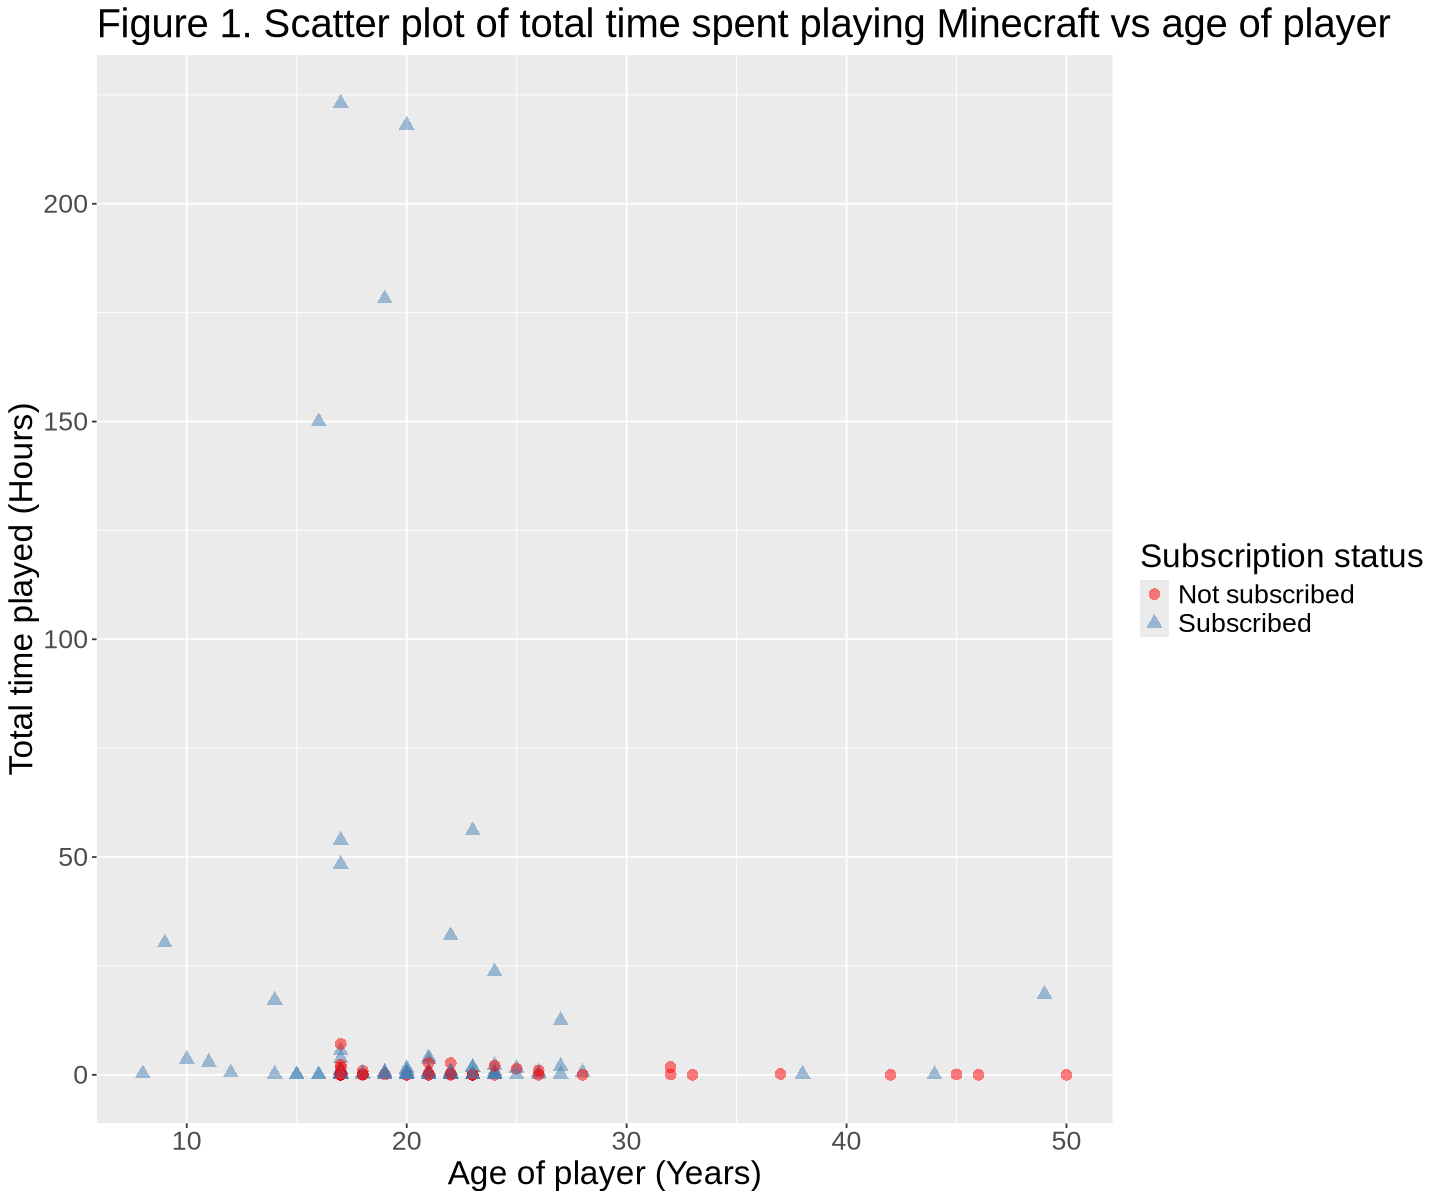

In [47]:
options(repr.plot.width=6, repr.plot.height=5)
# Proprotion of subsribed vs not substribed
ggplot(players_data_clean, aes(x = subscribe, fill = subscribe)) +
  geom_bar(position = "dodge") +
  scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
  scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                    labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed")) +
  labs(
    x = "Subscription Status",
    y = "Number of Players",
    fill = "Subscribed", 
    title = "Number of Players by Subscription Status"
  ) +
  theme(text = element_text(size = 16),
       legend.position = "none")

players_data_clean |>
  summarise(percent_subscribed = mean(subscribe == TRUE) * 100)


# Scatter plot of played hours, age?

options(repr.plot.width=12, repr.plot.height=10)

players_hours_age_plot <- ggplot(players_data_clean, aes(x = Age,
                                                   y = played_hours,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Age of player (Years)",
        y = "Total time played (Hours)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of total time spent playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot

To investigates differences among player types.
the how gender varies among player types, which are categorical variables, use bar plot:


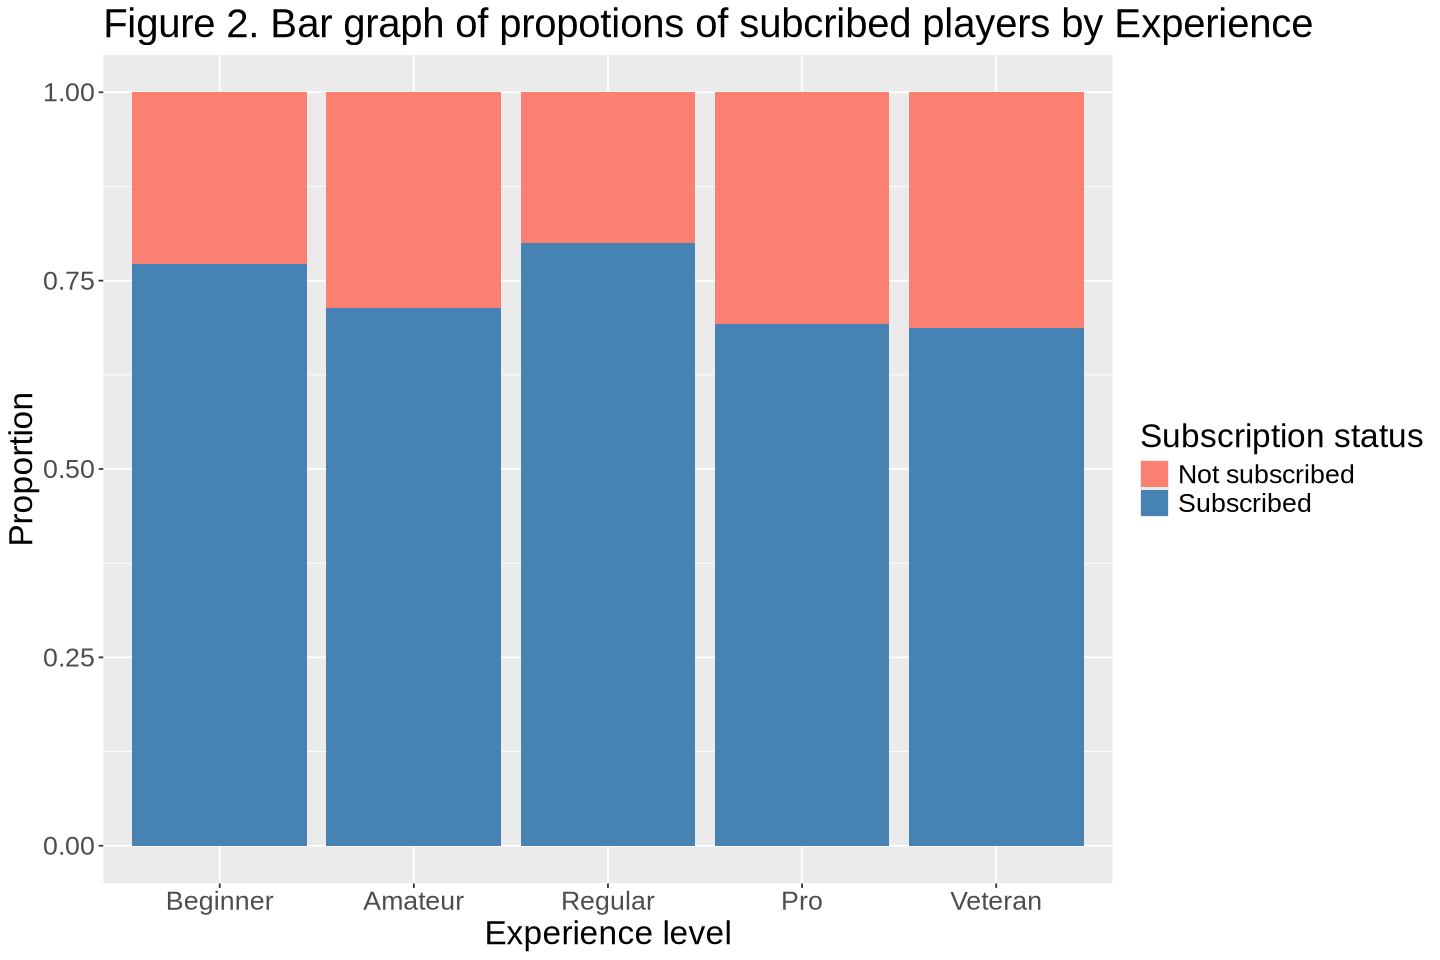

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

# Order from least experienced to most experienced
players_data_clean$experience <- factor(players_data_clean$experience,
                                  levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

experience_plot <- players_data_clean |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Experience level",
        y = "Proportion", 
        fill = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 2. Bar graph of propotions of subcribed players by Experience") +
        scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

experience_plot

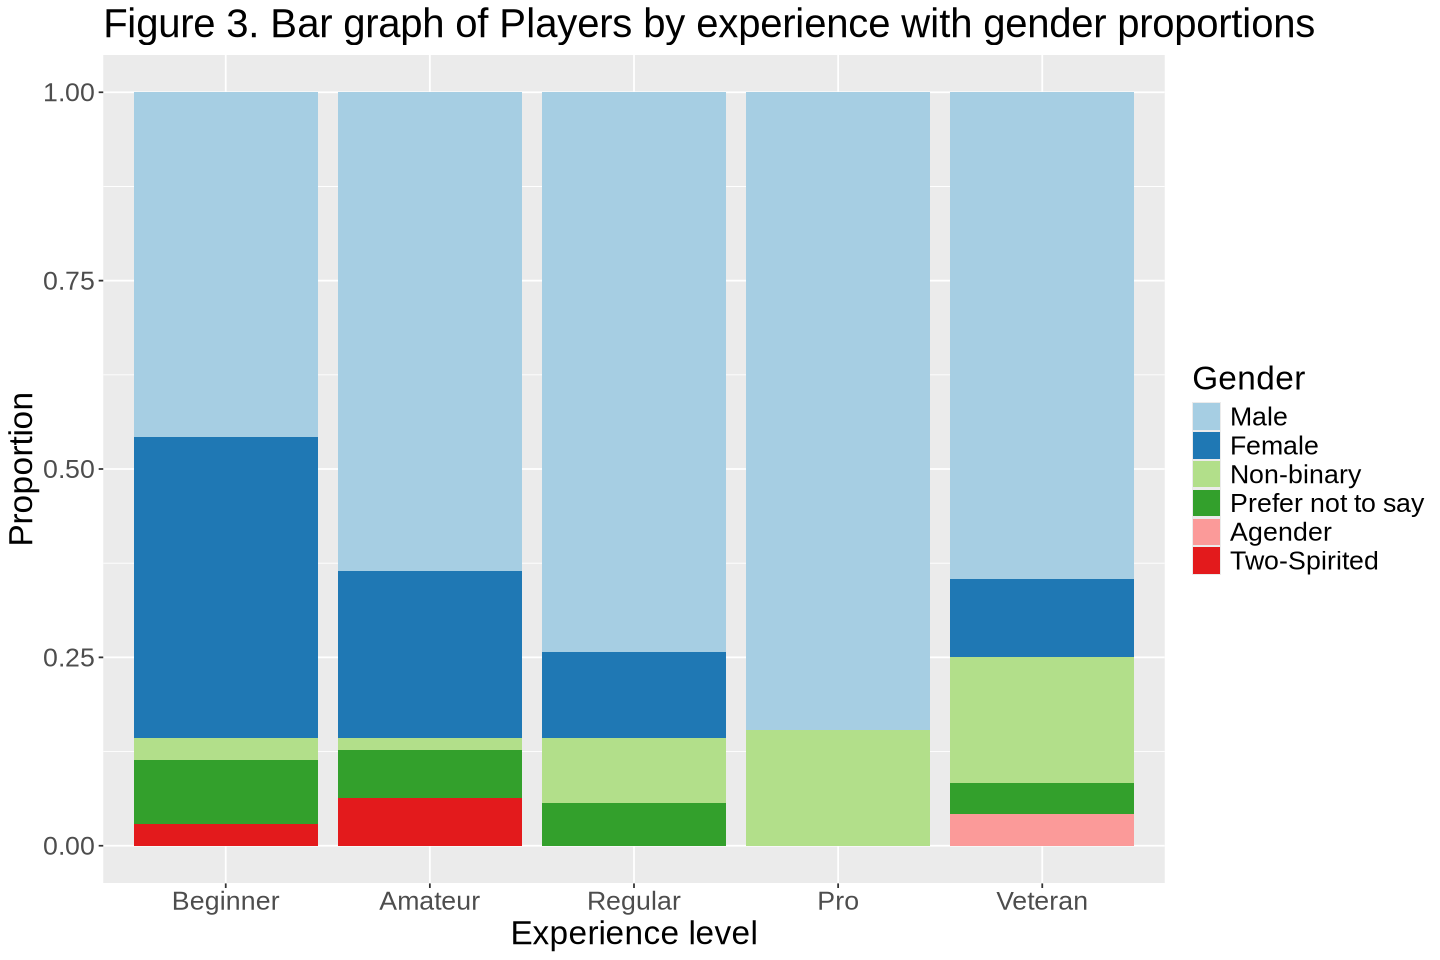

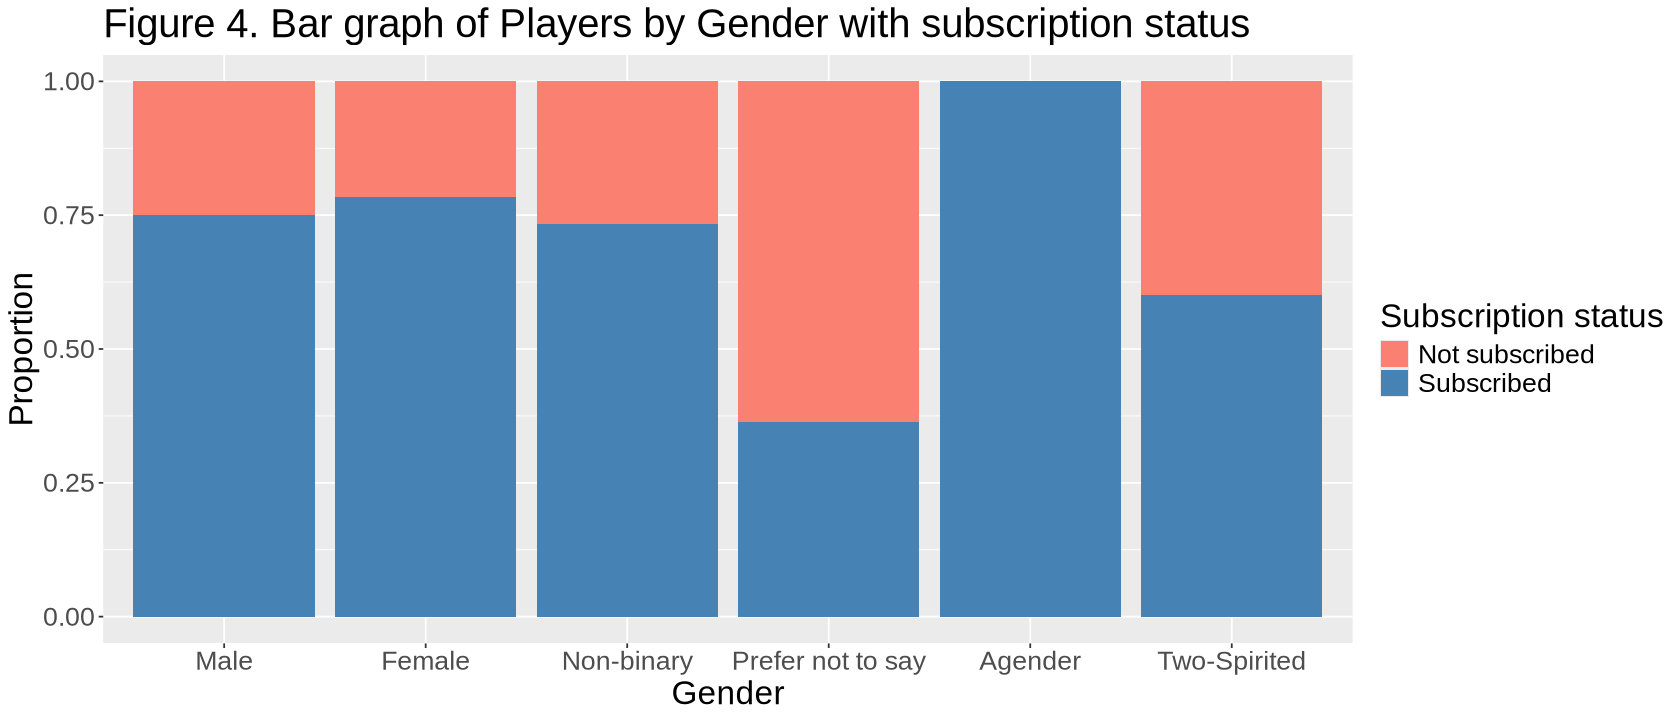

In [6]:
## Let's look at gender:
options(repr.plot.width=12, repr.plot.height=8)

experience_gender_plot <- players_data_clean |>
    ggplot(aes(x = experience, fill = gender)) +
    geom_bar(position = "fill") + #fill/dodge/stack
    labs(x = "Experience level",
        y = "Proportion", 
        fill = "Gender") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 3. Bar graph of Players by experience with gender proportions") +
        # scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
        #                labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))
        scale_fill_brewer(palette = "Paired")

experience_gender_plot


options(repr.plot.width=14, repr.plot.height=6)
gender_subscribe_plot <- players_data_clean |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") + #fill/dodge/stack
    labs(x = "Gender",
        y = "Proportion", 
        fill = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 4. Bar graph of Players by Gender with subscription status") +
        scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) #+
        #scale_fill_brewer(palette = "Paired")

gender_subscribe_plot


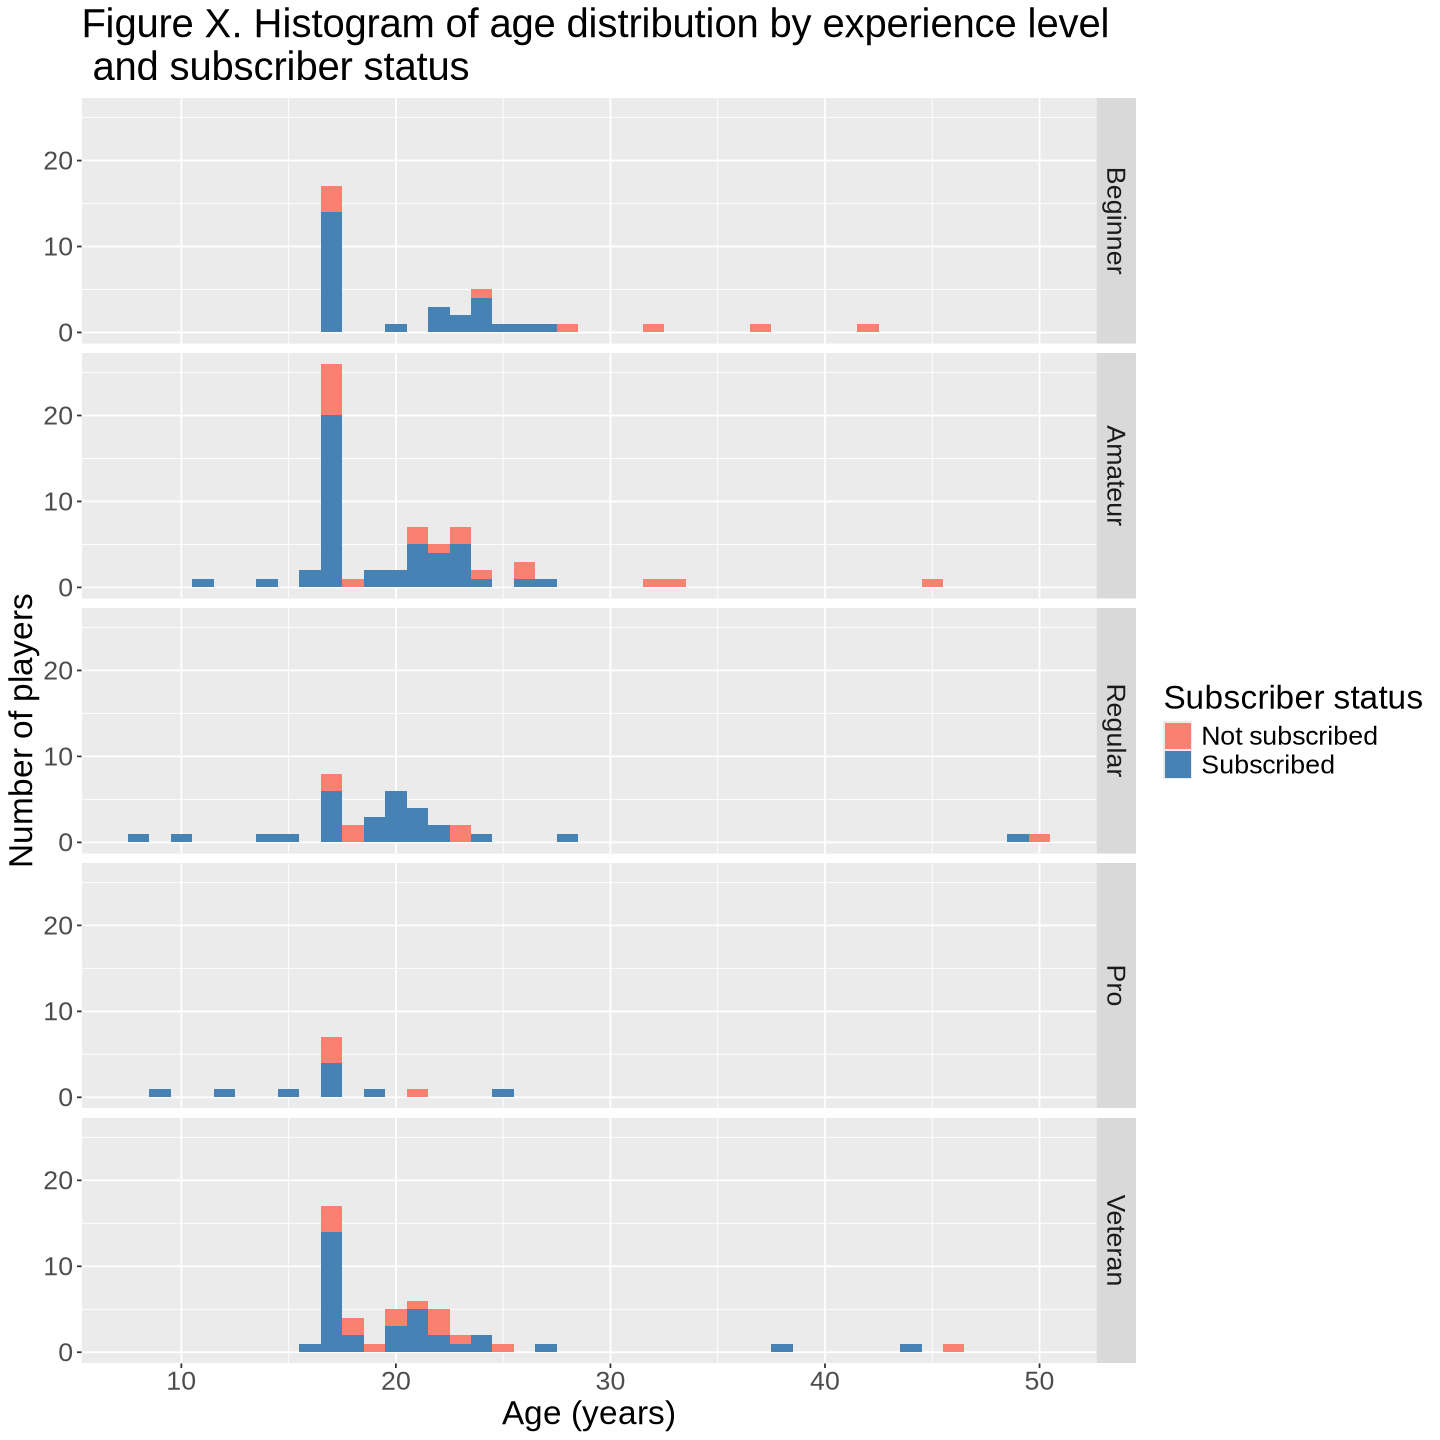

In [7]:
## !!! LOOK AT AGE DISTRIBUTION OF Each experience level

# Histogram of Age distribution by experience level
options(repr.plot.width=12, repr.plot.height=12)

player_beginner <- players_data_clean |>
  filter(experience == "Beginner")

player_amateur <- players_data_clean |>
  filter(experience == "Amateur")

player_regular <- players_data_clean |>
  filter(experience == "Regular")

player_pro <- players_data_clean |>
  filter(experience == "Pro")

player_veteran <- players_data_clean |>
  filter(experience == "Veteran")

selected_binwidth = 1

age_dist_experience <- players_data_clean |>
  ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = selected_binwidth) +
  facet_grid(rows = vars(experience)) +
  labs(x = "Age (years)", y = "Number of players", fill = "Subscriber status") +
  theme(text = element_text(size = 20)) +
  ggtitle("Figure X. Histogram of age distribution by experience level \n and subscriber status") +
  scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                    labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

age_dist_experience

Next, look at behavior. We will look at two aspects of behavior: duration of session, frequency of session. We first create a summary 

In [8]:
# Calculate duration of each session
sessions_data_clean <- sessions_data_clean |>
    mutate(duration = end_time - start_time)

# Calculate mean and max duration per session and frequency (total number of sessions) for each player
sessions_data_summary <- sessions_data_clean |>
    group_by(hashedEmail) |>
    summarize(mean_duration = mean(duration),
              max_duration = max(duration),
             frequency = n())

# Use left join to merge player info and sessions summary info
# so that all players are kept, including those with no sessions
player_info_sessions_summary <- players_data_clean |>
    left_join(sessions_data_summary, by = "hashedEmail")

# For players with no sessions set mean_duration, max_duration and frequency to 0
player_info_sessions_summary <- player_info_sessions_summary |>
    mutate(mean_duration = replace_na(mean_duration, as.duration(0)),
           max_duration = replace_na(max_duration, as.duration(0)),
           frequency = replace_na(frequency, 0))

# convert all the durations to integers/doubles in order to do standardization later
player_info_sessions_summary <- player_info_sessions_summary |>
    mutate(mean_duration = as.numeric(mean_duration),
           max_duration = as.numeric(max_duration))

player_info_sessions_summary

experience subscribe
1   Pro        TRUE     
2   Veteran    TRUE     
3   Veteran    FALSE    
⋮   ⋮          ⋮        
192 Veteran    FALSE    
193 Amateur    FALSE    
194 Amateur    FALSE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
192 71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd
193 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
194 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
    played_hours name      gender            Age mean_duration max_duration
1   30.3         Morgan    Male               9  74.77778      211         
2    3.8         Christian Male              17  85.00000      160         
3    0.0         Blake     Male              17   5.00000        5         
⋮   ⋮            ⋮         ⋮                 ⋮   ⋮             ⋮           
192 0.3          Pascal    Male              22  21.00000       21         
193 0.0          Dylan     Prefer not to say 17   5.00000        5         
194 2.3          Harlow    Male              17  29.83333      118         
    frequency
1   27       
2    3       
3    1       
⋮   ⋮        
192 1        
193 1        
194 6

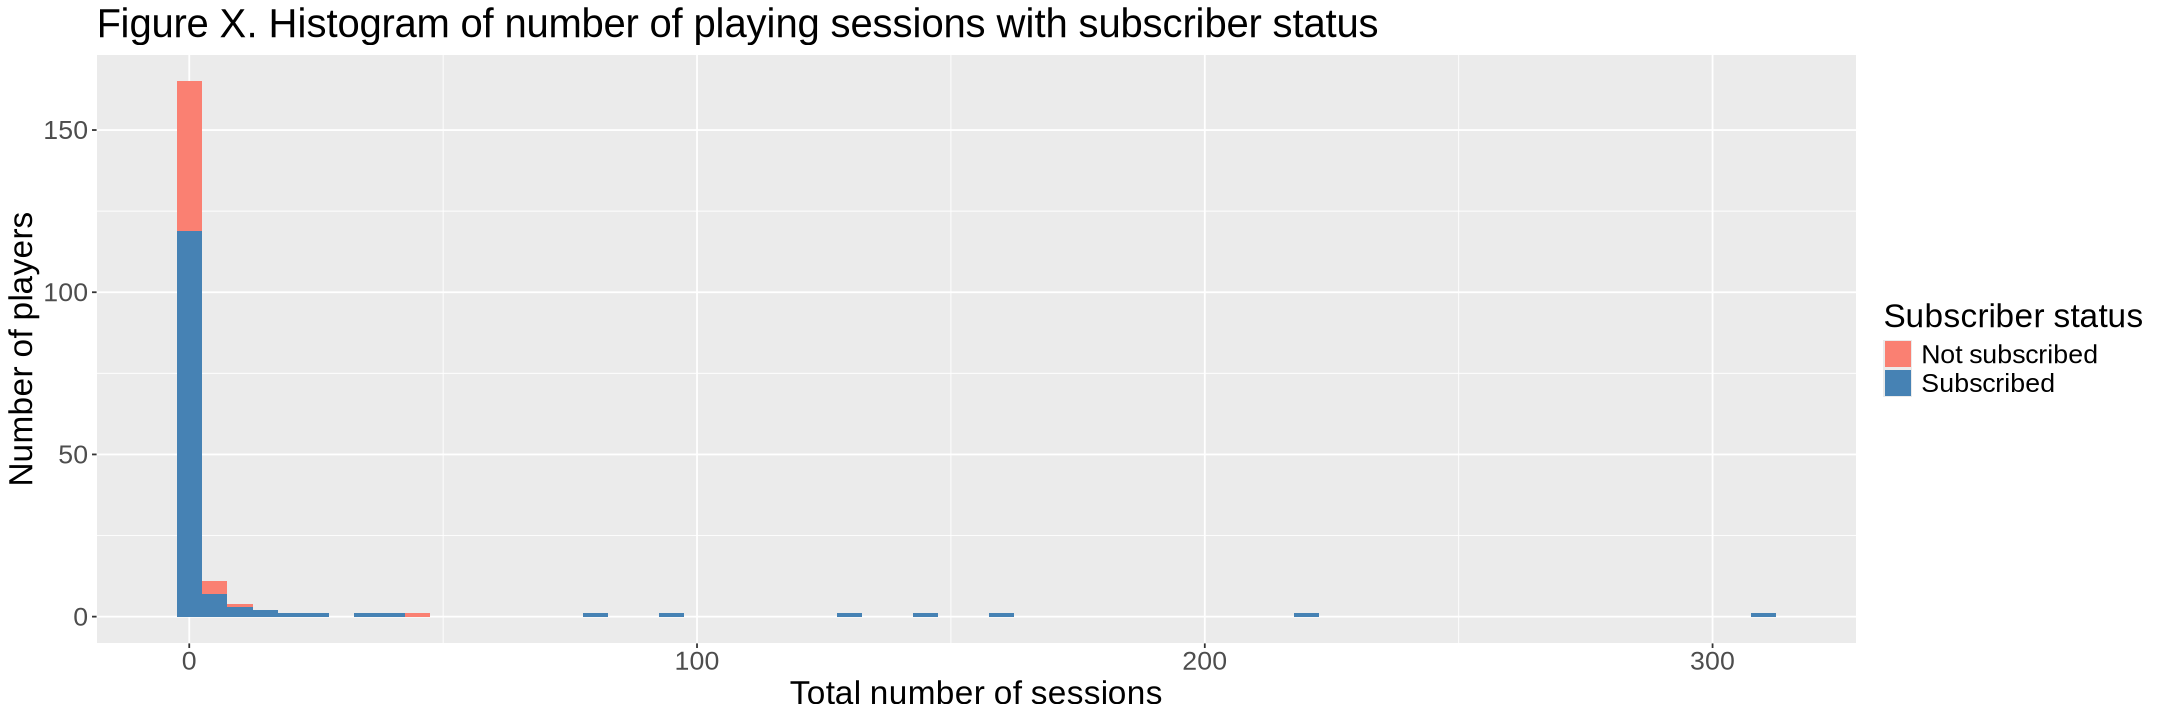

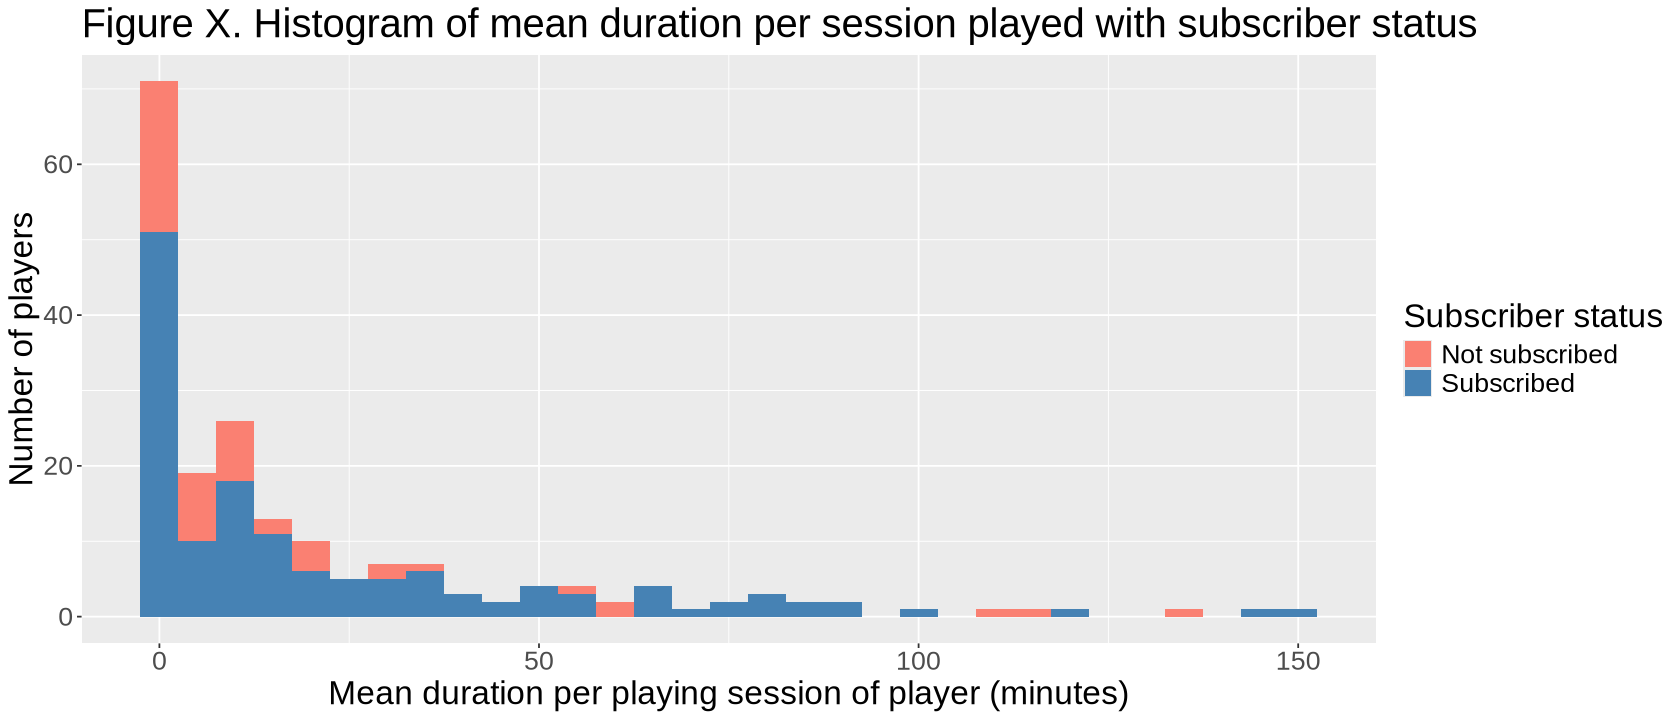

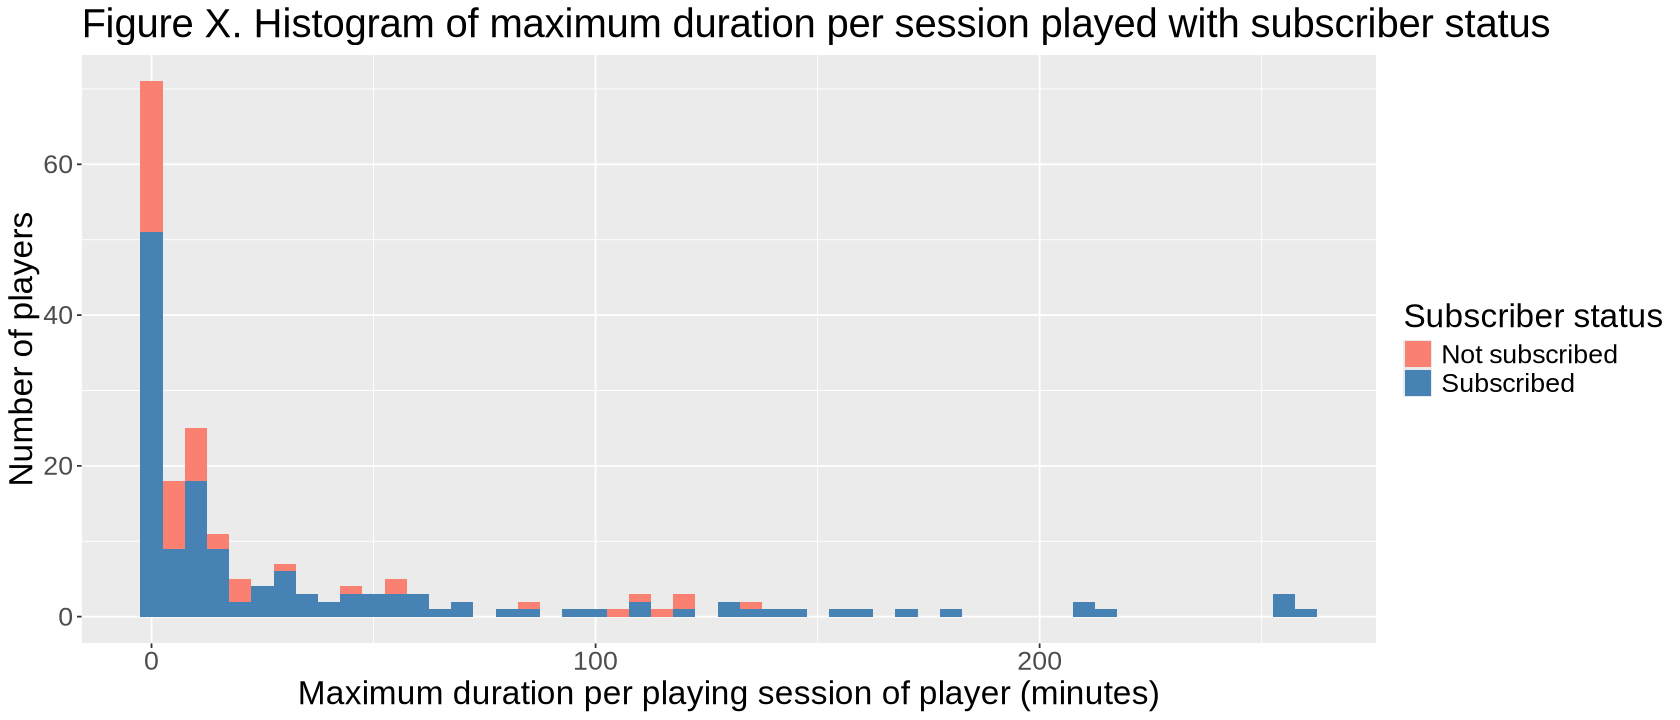

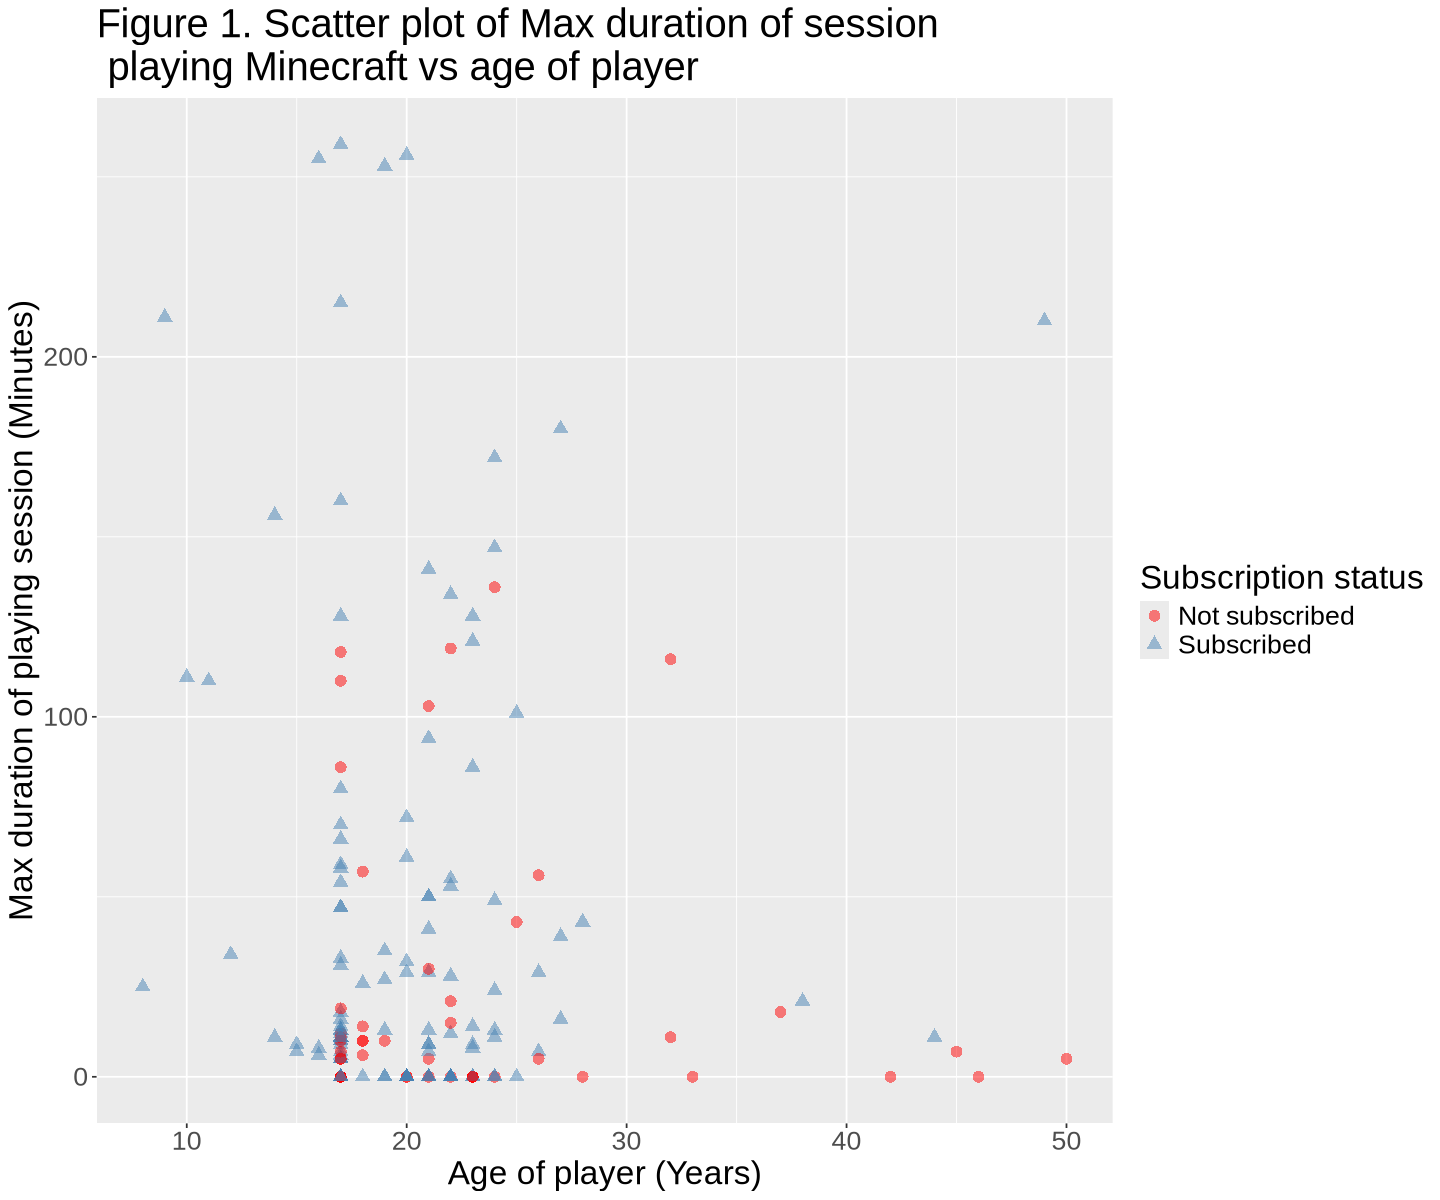

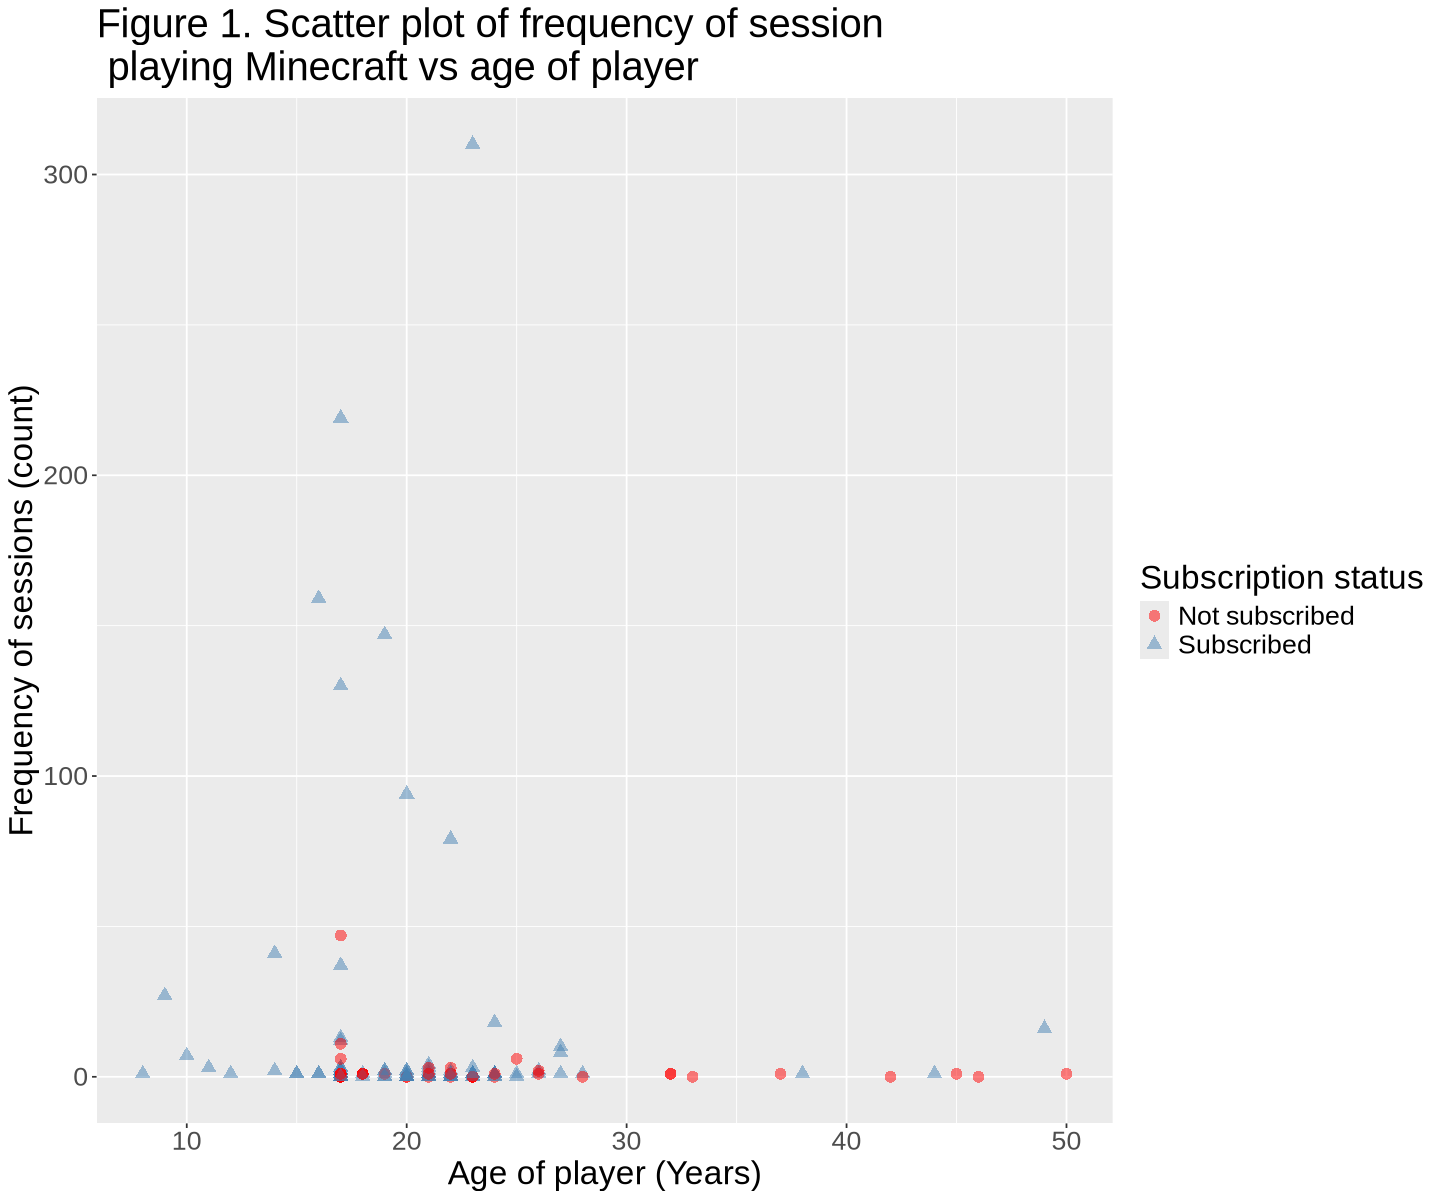

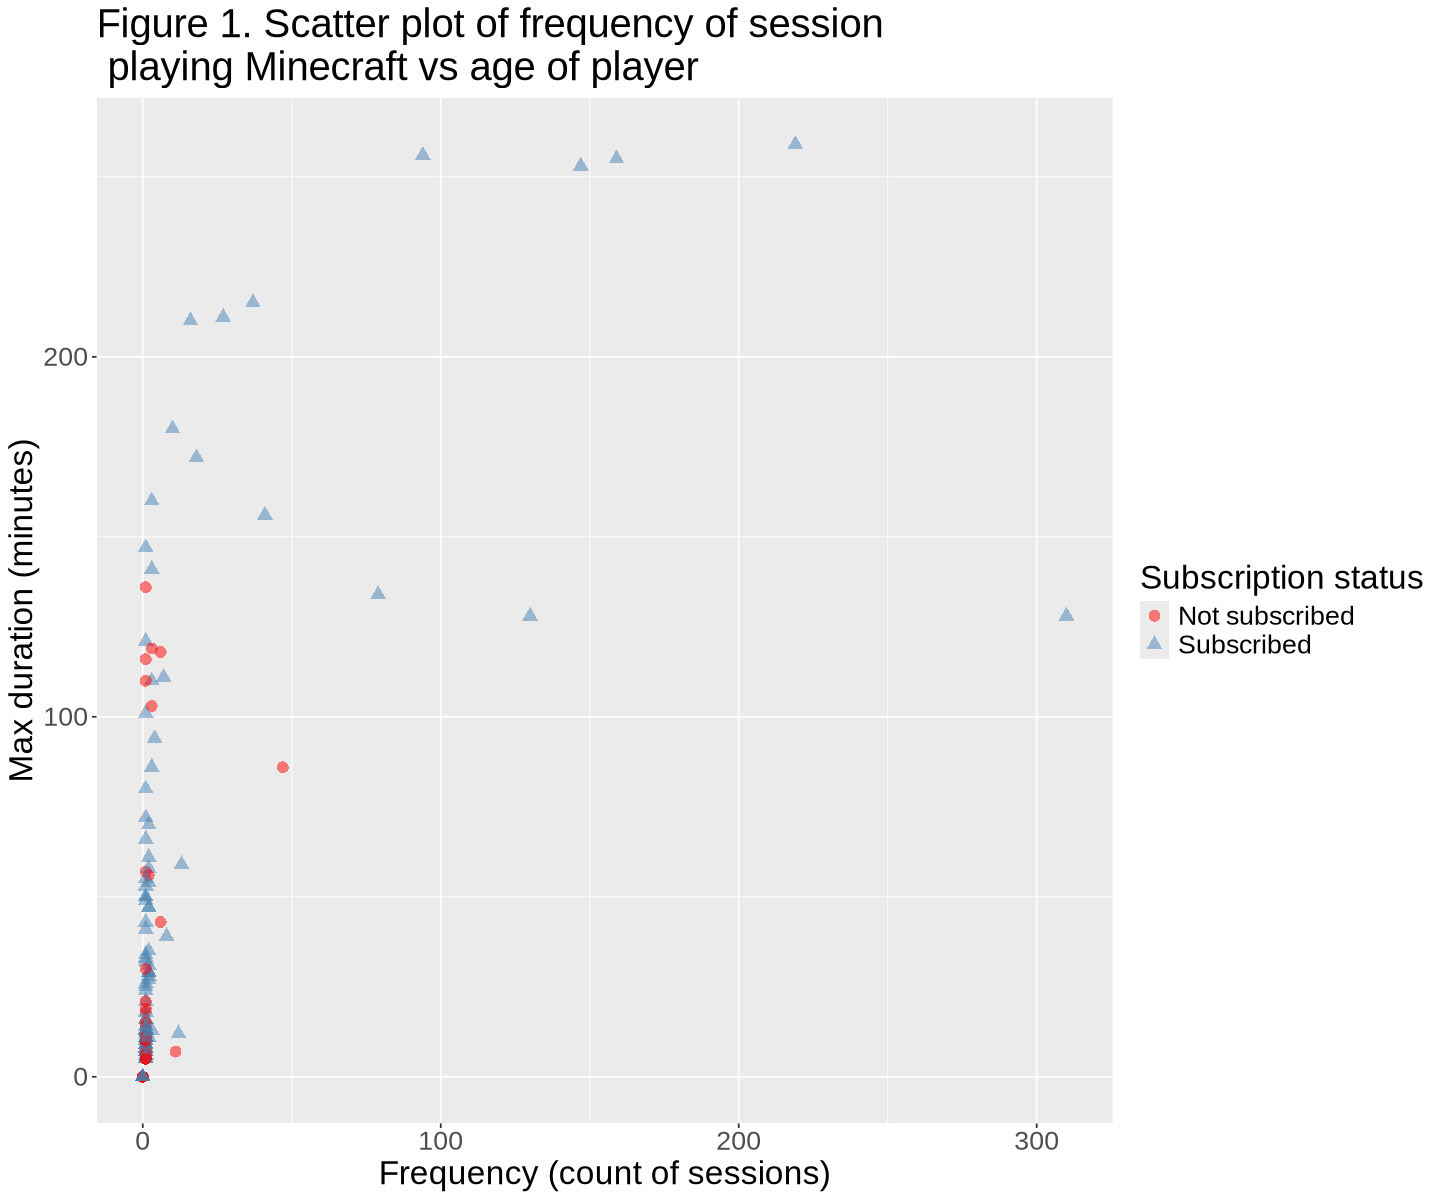

In [9]:
options(repr.plot.width=18, repr.plot.height=6)

selected_binwidth = 5

# Histrogram of frequency
hist_mean_freq_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = frequency, fill = subscribe)) +
    geom_histogram(binwidth = selected_binwidth) +
    labs(x = "Total number of sessions",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of number of playing sessions with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_mean_freq_subscribe


# Histogram of Mean Duration
options(repr.plot.width=14, repr.plot.height=6)

hist_mean_duration_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = mean_duration, fill = subscribe)) +
    geom_histogram(binwidth = selected_binwidth) +
    labs(x = "Mean duration per playing session of player (minutes)",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of mean duration per session played with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_mean_duration_subscribe

# Histogram of Max Duration
              
hist_max_duration_subscribe <- player_info_sessions_summary |>
    ggplot(aes(x = max_duration, fill = subscribe)) +
    geom_histogram(binwidth = selected_binwidth) +
    labs(x = "Maximum duration per playing session of player (minutes)",
        y = "Number of players",
        fill = "Subscriber status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure X. Histogram of maximum duration per session played with subscriber status") +
    scale_fill_manual(values = c("FALSE" = "salmon", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))

hist_max_duration_subscribe


# Age and max duration


options(repr.plot.width=12, repr.plot.height=10)

players_hours_age_plot <- ggplot(player_info_sessions_summary, aes(x = Age,
                                                   y = max_duration,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Age of player (Years)",
        y = "Max duration of playing session (Minutes)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of Max duration of session \n playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot

# Age and frequency

players_hours_age_plot <- ggplot(player_info_sessions_summary, aes(x = Age,
                                                   y = frequency,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Age of player (Years)",
        y = "Frequency of sessions (count)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of frequency of session \n playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot


# frequency and max duration
players_hours_age_plot <- ggplot(player_info_sessions_summary, aes(x = frequency,
                                                   y = max_duration,
                                                   color = subscribe,
                                                   shape = subscribe)) +
    geom_point(size = 3, alpha = 0.5) +
    labs(x = "Frequency (count of sessions)",
        y = "Max duration (minutes)", 
        color = "Subscription status",
        shape = "Subscription status") +
        theme(text = element_text(size = 20)) +
        ggtitle("Figure 1. Scatter plot of frequency of session \n playing Minecraft vs age of player") +
        scale_color_manual(values = c("FALSE" = "red", "TRUE" = "steelblue"),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed")) +
        scale_shape_manual(values = c("FALSE" = 16, "TRUE" = 17),
                       labels = c("FALSE" = "Not subscribed", "TRUE" = "Subscribed"))


players_hours_age_plot

Doesn't appear to be a strong relationship between subscription status and mean duration of session. Could be more subscribers among those that play short up to 10 min sessions at at time. Then another high proprotion at 100+ minutes average session

Let's try to create a classification model with the following numeric predictors:
1. age
2. total time spent playing the game
3. max session duration
4. frequency of sessions

And compared to classificaiton with all predictors?

In [10]:
# For readability, we will call the combined player information and sessions summary player_data as just data
player_data <- player_info_sessions_summary

# Split data into training and testing subsets

player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

# 10-fold cross-validation on the training set
player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

# Create the knn model specifications for tuning K
player_knn <- nearest_neighbor(weight_func = "rectangular",
                               neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

# Create a tibble of K values to try
k_vals <- tibble(neighbors = seq(from = 5, to = 50, by = 2))

Let's look at pairs of predictors and all 4 predictors that appear to affect subscription.
Based on results above, it we will try

1. Age + total hours played
2. Age + Max duration of a session
3. Age + Frequency
4. All 4 predictors above: Age + total hours played + Max duration of a session + Frequency

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6167033 10 0.04153143  Preprocessor1_Model01
2  5         roc_auc  binary     0.6100000 10 0.04728990  Preprocessor1_Model01
3  7         accuracy binary     0.6367033 10 0.05126989  Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
44 47        roc_auc  binary     0.5521591 10 0.067763966 Preprocessor1_Model22
45 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23
46 49        roc_auc  binary     0.5178030 10 0.059412811 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6167033 10 0.04153143  Preprocessor1_Model01
2  7         accuracy binary     0.6367033 10 0.05126989  Preprocessor1_Model02
3  9         accuracy binary     0.6167033 10 0.04384507  Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 45        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model21
22 47        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model22
23 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  19        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model08
2  21        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model09
3  23        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model10
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 11        accuracy binary     0.6254212 10 0.03859713  Preprocessor1_Model04
22  5        accuracy binary     0.6167033 10 0.04153143  Preprocessor1_Model01
23  9        accuracy binary     0.6167033 10 0.04384507  Preprocessor1_Model03

[1] 19

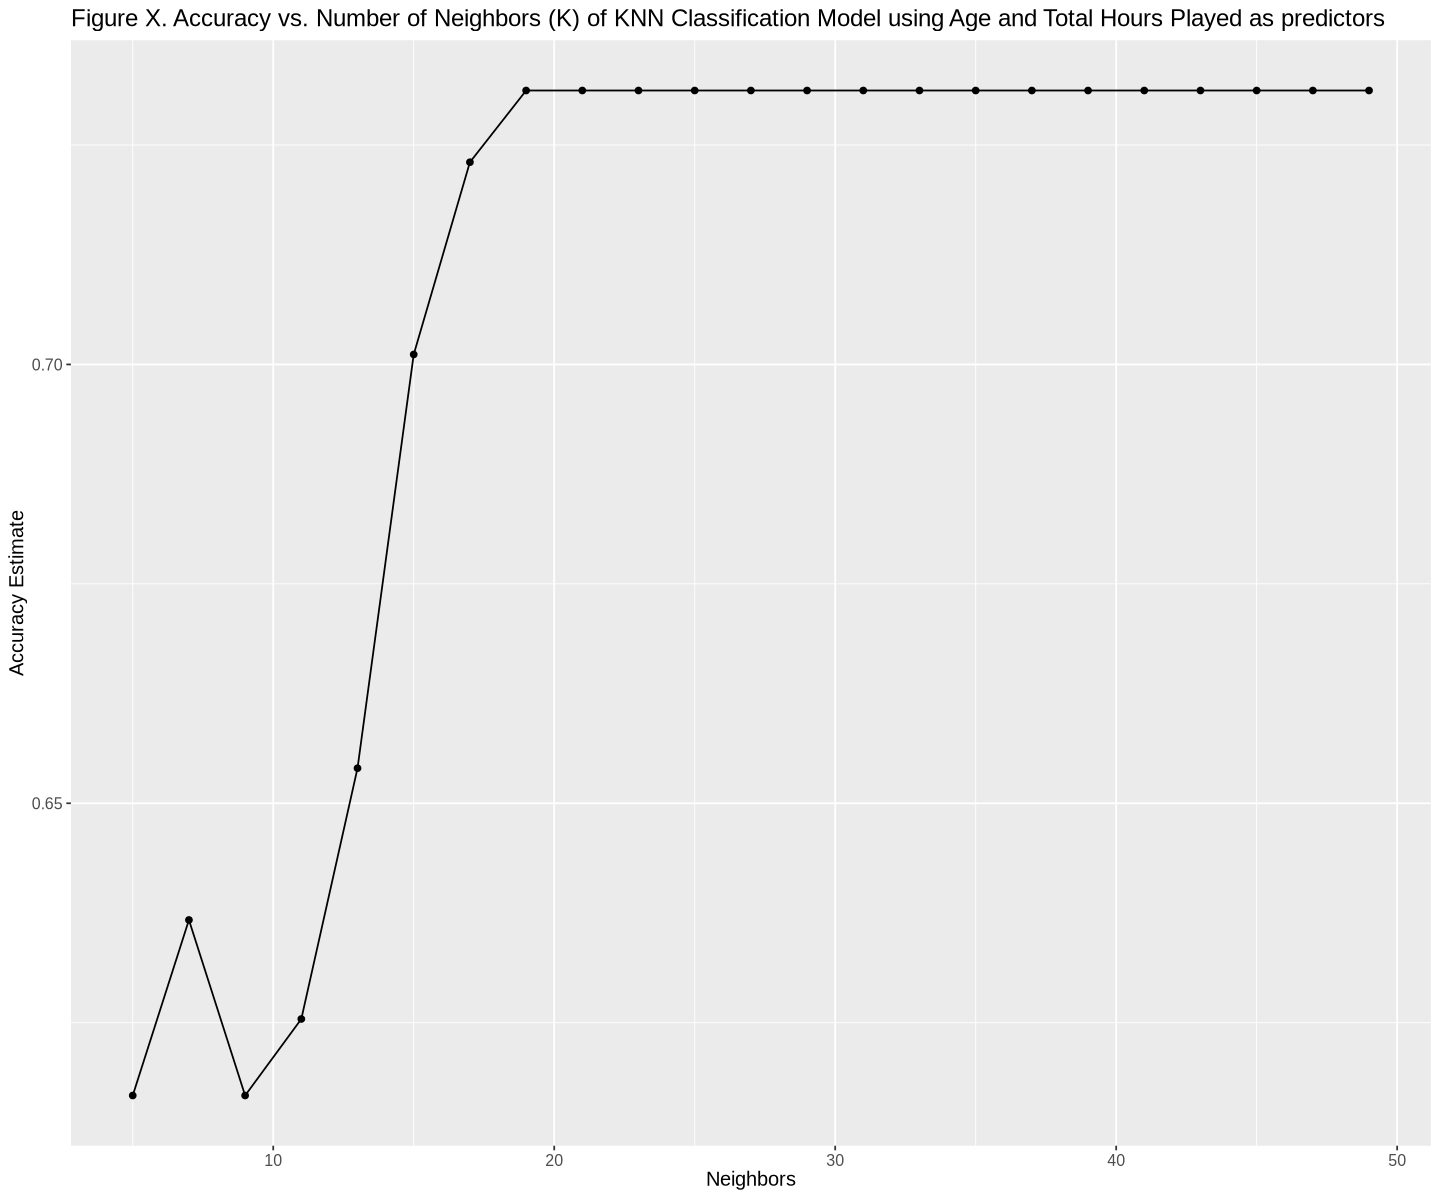

In [22]:
# === Predicting Subscription status by Age + Total Hours played ===

recipe_age_hours <- recipe(subscribe ~ Age + played_hours,
                     data = player_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

# Use tune_grid to fit the model
# Collect the metricsm filter for "accuracy"
# Plot accuracy vs K
knn_results_age_hours <- workflow() |>
    add_recipe(recipe_age_hours) |>
    add_model(player_knn) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

knn_results_age_hours

# Tune k-NN model with 5-fold CV
knn_accuracy_age_hours <- knn_results_age_hours |>
    filter(.metric == "accuracy")

knn_accuracy_age_hours

# Plot accuracy vs. number of neighbors
knn_age_hours_plot <- knn_accuracy_age_hours |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure X. Accuracy vs. Number of Neighbors (K) of KNN Classification Model using Age and Total Hours Played as predictors") +
    theme(text = element_text(size = 12))

knn_age_hours_plot

knn_results_age_hours_sorted <- knn_accuracy_age_hours |>
    arrange(desc(mean))

knn_results_age_hours_sorted

best_k_age_hours <- knn_results_age_hours_sorted |>
    head(1) |>
    pull(neighbors)

best_k_age_hours

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6868498 10 0.04106895  Preprocessor1_Model01
2  5         roc_auc  binary     0.5935985 10 0.04872083  Preprocessor1_Model01
3  7         accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
44 47        roc_auc  binary     0.5539773 10 0.043534000 Preprocessor1_Model22
45 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23
46 49        roc_auc  binary     0.5526136 10 0.037663041 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6868498 10 0.04106895  Preprocessor1_Model01
2  7         accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
3  9         accuracy binary     0.6330403 10 0.03700946  Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 45        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model21
22 47        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model22
23 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err    .config              
1  15        accuracy binary     0.7512088 10 0.01179222 Preprocessor1_Model06
2  17        accuracy binary     0.7445421 10 0.01498654 Preprocessor1_Model07
3  25        accuracy binary     0.7440659 10 0.01576974 Preprocessor1_Model11
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮          ⋮                    
21 5         accuracy binary     0.6868498 10 0.04106895 Preprocessor1_Model01
22 7         accuracy binary     0.6868498 10 0.03984838 Preprocessor1_Model02
23 9         accuracy binary     0.6330403 10 0.03700946 Preprocessor1_Model03

[1] 15

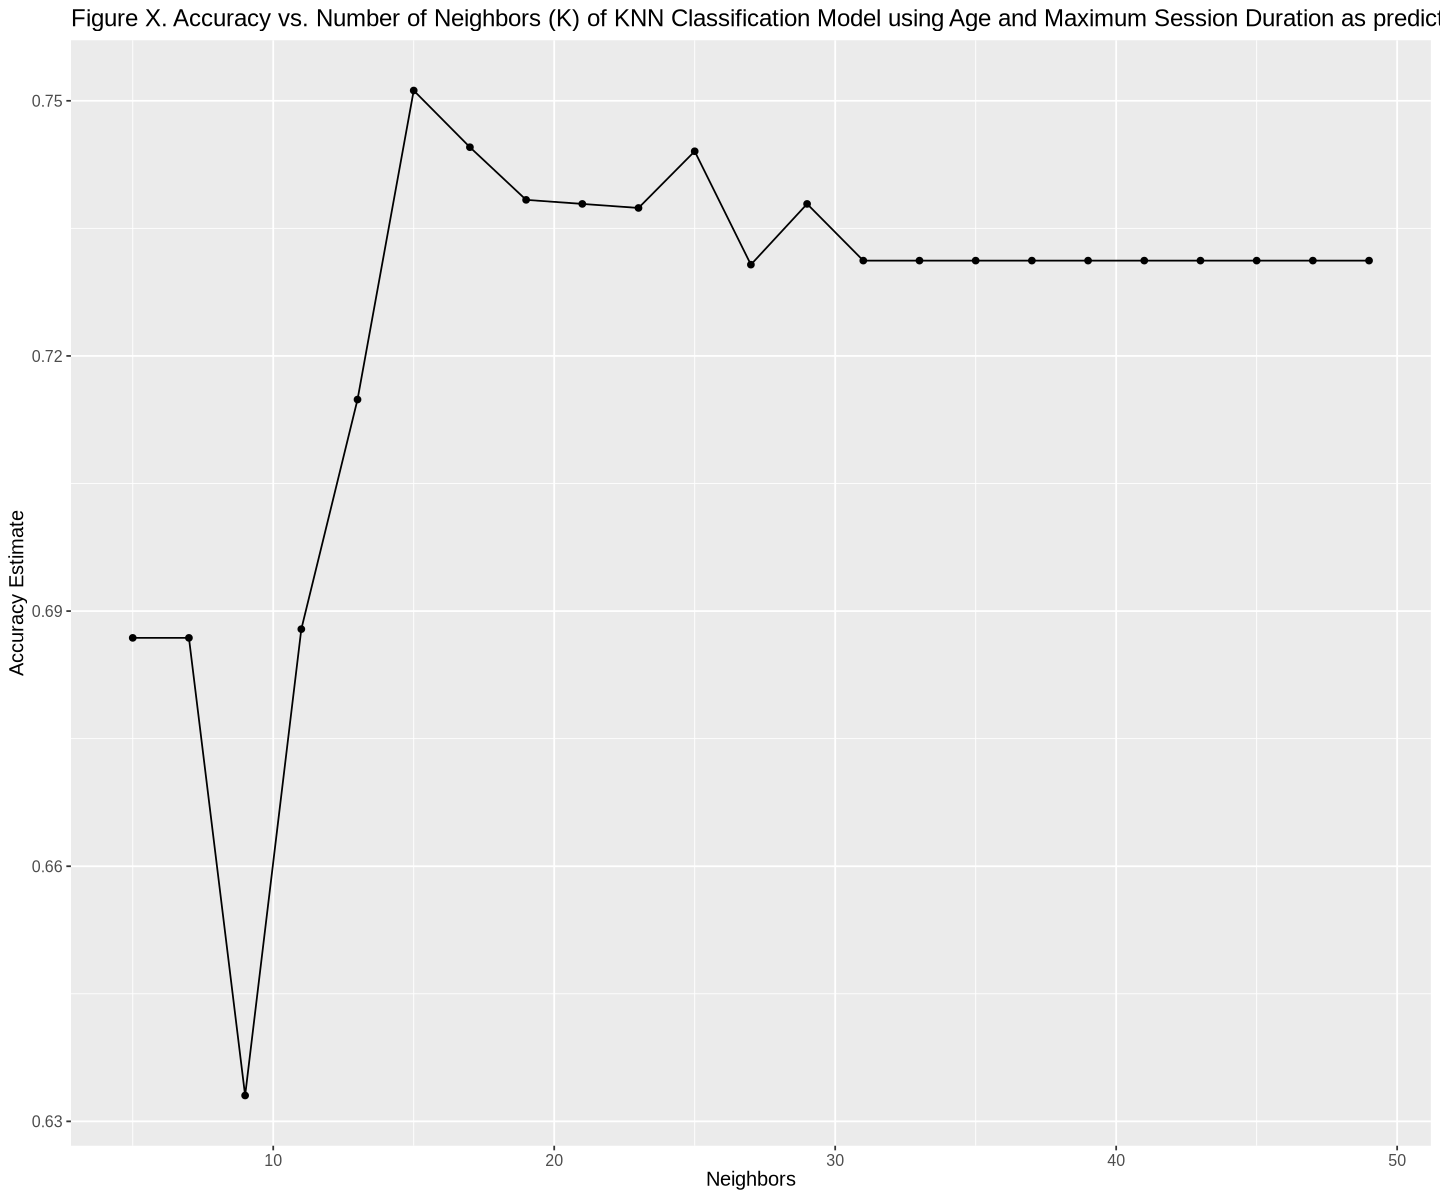

In [25]:
# === Predicting Subscription status by Age + Maximum duration of a session ===

# Create recipes for pairs of predictors using training data
recipe_age_max <- recipe(subscribe ~ Age + max_duration,
                     data = player_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

# Use tune_grid to fit the model
# Collect the metricsm filter for "accuracy"
# Plot accuracy vs K

knn_results_age_max <- workflow() |>
    add_recipe(recipe_age_max) |>
    add_model(player_knn) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

knn_results_age_max

# Tune k-NN model with 5-fold CV
knn_accuracy_age_max <- knn_results_age_max |>
    filter(.metric == "accuracy")

knn_accuracy_age_max

# Plot accuracy vs. number of neighbors
knn_age_max_plot <- knn_accuracy_age_max |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure X. Accuracy vs. Number of Neighbors (K) of KNN Classification Model using Age and Maximum Session Duration as predictors") +
    theme(text = element_text(size = 12))

knn_age_max_plot

knn_results_age_max_sorted <- knn_accuracy_age_max |>
    arrange(desc(mean))

knn_results_age_max_sorted

best_k_age_max <- knn_results_age_max_sorted |>
    head(1) |>
    pull(neighbors)

best_k_age_max

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6120147 10 0.03096165  Preprocessor1_Model01
2  5         roc_auc  binary     0.6026894 10 0.04220385  Preprocessor1_Model01
3  7         accuracy binary     0.6515385 10 0.04598807  Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
44 47        roc_auc  binary     0.5120833 10 0.064430779 Preprocessor1_Model22
45 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23
46 49        roc_auc  binary     0.5148485 10 0.068852593 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6868498 10 0.04106895  Preprocessor1_Model01
2  7         accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
3  9         accuracy binary     0.6330403 10 0.03700946  Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 45        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model21
22 47        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model22
23 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  17        accuracy binary     0.7373260 10 0.010240183 Preprocessor1_Model07
2  13        accuracy binary     0.7358974 10 0.024473933 Preprocessor1_Model05
3  19        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model08
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 7         accuracy binary     0.6515385 10 0.04598807  Preprocessor1_Model02
22 9         accuracy binary     0.6177289 10 0.04991761  Preprocessor1_Model03
23 5         accuracy binary     0.6120147 10 0.03096165  Preprocessor1_Model01

[1] 17

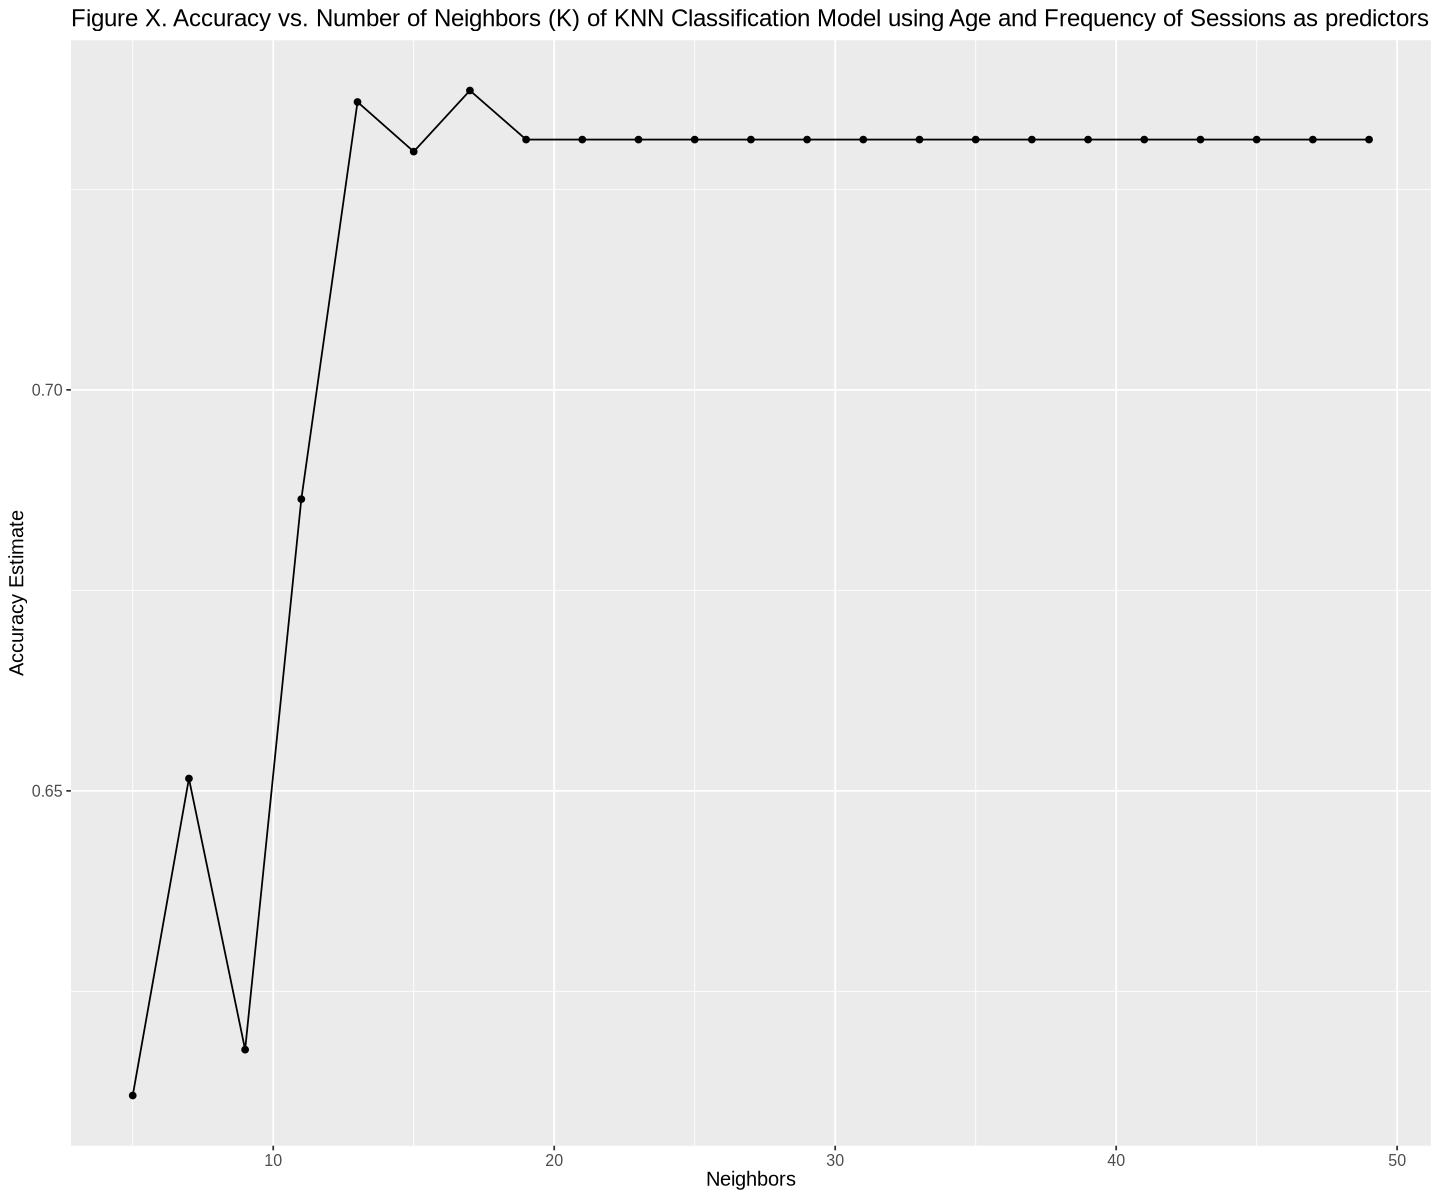

In [23]:
# === Predicting Subscription status by Age + Frequency of Sessions ===

# Create recipes for pairs of predictors using training data
recipe_age_freq <- recipe(subscribe ~ Age + frequency,
                     data = player_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

# Use tune_grid to fit the model
# Collect the metricsm filter for "accuracy"
# Plot accuracy vs K

knn_results_age_freq <- workflow() |>
    add_recipe(recipe_age_freq) |>
    add_model(player_knn) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

knn_results_age_freq

knn_accuracy_age_freq <- knn_results_age_freq |>
    filter(.metric == "accuracy")

knn_accuracy_age_max

# Plot accuracy vs. number of neighbors
knn_age_freq_plot <- knn_accuracy_age_freq |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure X. Accuracy vs. Number of Neighbors (K) of KNN Classification Model using Age and Frequency of Sessions as predictors") +
    theme(text = element_text(size = 12))

knn_age_freq_plot

knn_results_age_freq_sorted <- knn_accuracy_age_freq |>
    arrange(desc(mean))

knn_results_age_freq_sorted

best_k_age_freq <- knn_results_age_freq_sorted |>
    head(1) |>
    pull(neighbors)

best_k_age_freq

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6939927 10 0.03942678  Preprocessor1_Model01
2  5         roc_auc  binary     0.5767045 10 0.05180380  Preprocessor1_Model01
3  7         accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
44 47        roc_auc  binary     0.5634470 10 0.043393922 Preprocessor1_Model22
45 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23
46 49        roc_auc  binary     0.5362879 10 0.028213231 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  5         accuracy binary     0.6939927 10 0.03942678  Preprocessor1_Model01
2  7         accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
3  9         accuracy binary     0.6330403 10 0.03700946  Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21 45        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model21
22 47        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model22
23 49        accuracy binary     0.7312088 10 0.005090213 Preprocessor1_Model23

neighbors .metric  .estimator mean      n  std_err     .config              
1  25        accuracy binary     0.7440659 10 0.015769745 Preprocessor1_Model11
2  21        accuracy binary     0.7378755 10 0.008573342 Preprocessor1_Model09
3  29        accuracy binary     0.7378755 10 0.008573342 Preprocessor1_Model13
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
21  7        accuracy binary     0.6868498 10 0.03984838  Preprocessor1_Model02
22 11        accuracy binary     0.6730403 10 0.03861119  Preprocessor1_Model04
23  9        accuracy binary     0.6330403 10 0.03700946  Preprocessor1_Model03

[1] 25

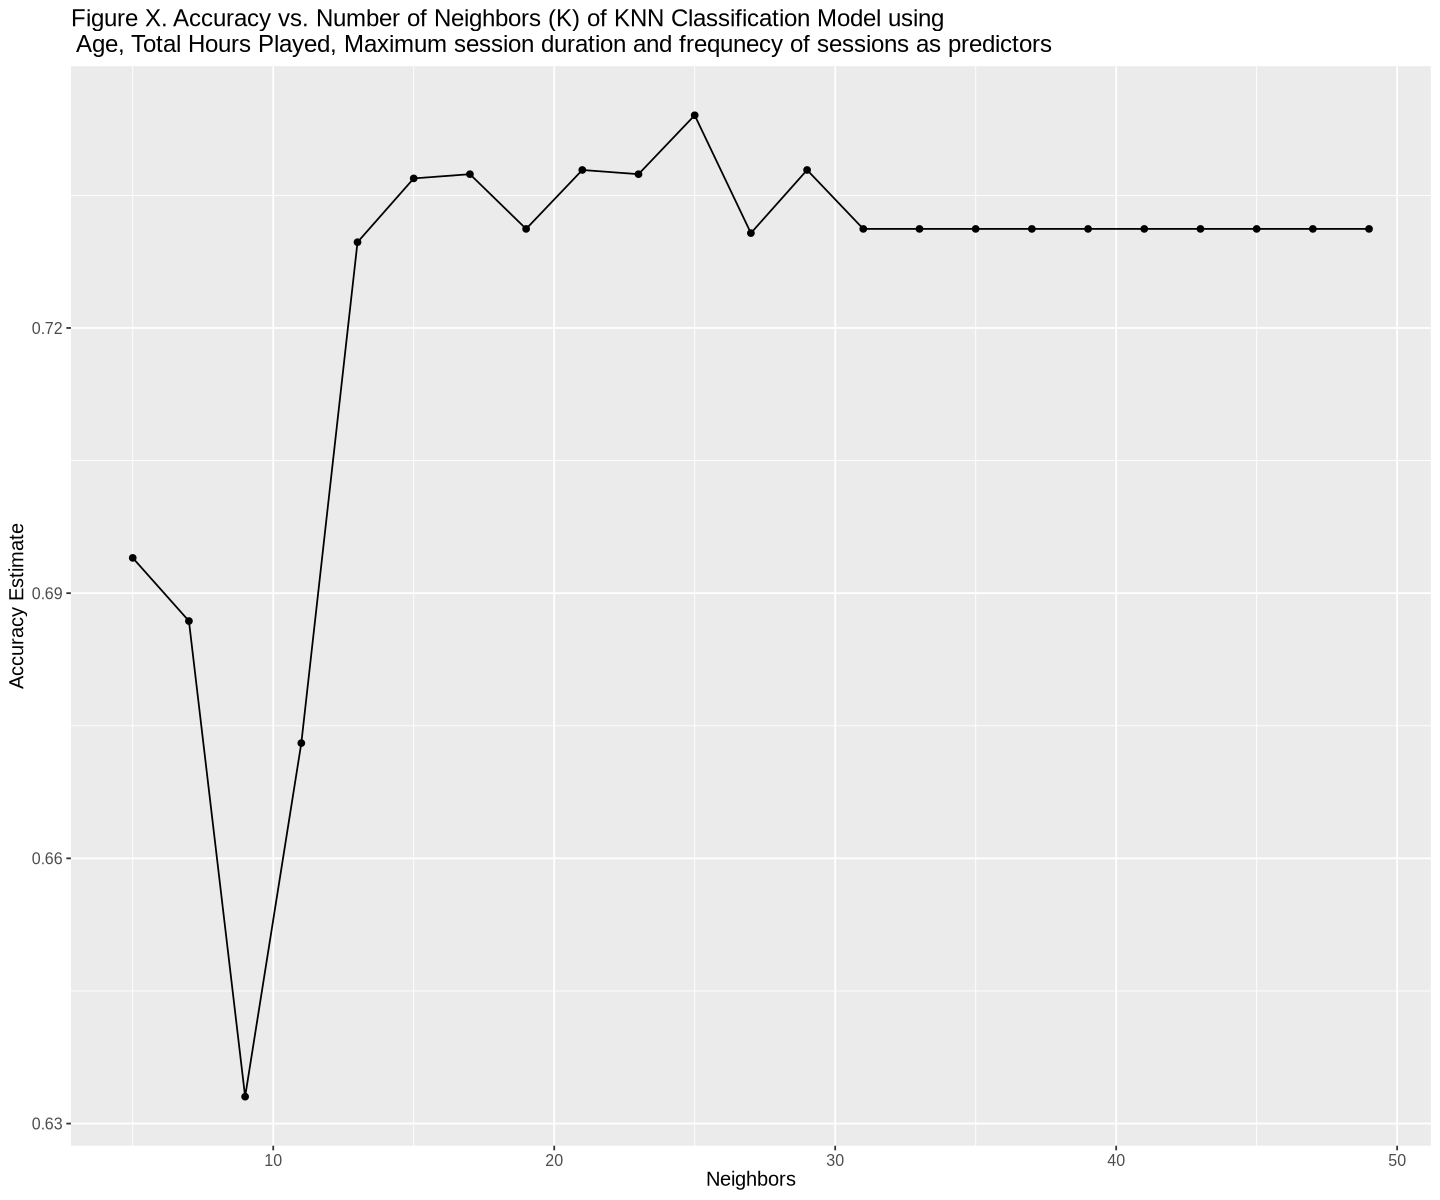

In [24]:
# === Predicting Subscription status by Age + Total Hours played + Max duration of a session + Frequency of Sessions ===

# Create recipes for pairs of predictors using training data
recipe_all <- recipe(subscribe ~ Age + played_hours + max_duration + frequency,
                     data = player_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

# Use tune_grid to fit the model
# Collect the metricsm filter for "accuracy"
# Plot accuracy vs K

knn_results_all <- workflow() |>
    add_recipe(recipe_all) |>
    add_model(player_knn) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

knn_results_all

# Tune k-NN model with 5-fold CV
knn_accuracy_all <- knn_results_all |>
    filter(.metric == "accuracy")

knn_accuracy_all

# Plot accuracy vs. number of neighbors
knn_all_plot <- knn_accuracy_all |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure X. Accuracy vs. Number of Neighbors (K) of KNN Classification Model using \n Age, Total Hours Played, Maximum session duration and frequnecy of sessions as predictors") +
    theme(text = element_text(size = 12))

knn_all_plot

knn_results_all_sorted <- knn_accuracy_all |>
    arrange(desc(mean))

knn_results_all_sorted

best_k_all <- knn_results_all_sorted |>
    head(1) |>
    pull(neighbors)

best_k_all

## Evaluation of models on test set

Now that we have our four models and their best Ks, let's evaluate the models on the test set:

In [31]:
# === Predicting Subscription status by Age + Total Hours played ===

# Re-train model with selected K
knn_spec_age_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_hours) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_age_hours <- workflow() |>
    add_recipe(recipe_age_hours) |>
    add_model(knn_spec_age_hours) |>
    fit(data = player_train)

# Predict on test set
player_pred_age_hours <- predict(knn_fit_age_hours, player_test) |>
    bind_cols(player_test)

# Check order of labels in the subscribe variable - [1] False [2] True
player_pred_age_hours |> pull(subscribe) |> levels()

player_pred_age_hours |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# Precision
player_pred_age_hours |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall
player_pred_age_hours |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# Confusion matrix
player_pred_age_hours |>
    conf_mat(truth = subscribe, estimate = .pred_class)

[1] "FALSE" "TRUE"

.metric  .estimator .estimate
1 accuracy binary     0.755102

.metric   .estimator .estimate
1 precision binary     0.75

.metric .estimator .estimate
1 recall  binary     1

          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE     12   36

In [33]:
# === Predicting Subscription status by Age + Max Session Duration ===

# Re-train model with best K for this predictor combo
knn_spec_age_max <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_max) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit the model using the recipe with Age + max_duration
knn_fit_age_max <- workflow() |>
  add_recipe(recipe_age_max) |>
  add_model(knn_spec_age_max) |>
  fit(data = player_train)

# Predict on the test set
player_pred_age_max <- predict(knn_fit_age_max, player_test) |>
  bind_cols(player_test)

# Optional: check label levels
player_pred_age_max |> pull(subscribe) |> levels()

# Accuracy
player_pred_age_max |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision (for positive class: subscribed == TRUE)
player_pred_age_max |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall (for positive class: subscribed == TRUE)
player_pred_age_max |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# Confusion matrix
player_pred_age_max |>
  conf_mat(truth = subscribe, estimate = .pred_class)

[1] "FALSE" "TRUE"

.metric  .estimator .estimate
1 accuracy binary     0.7346939

.metric   .estimator .estimate
1 precision binary     0.7446809

.metric .estimator .estimate
1 recall  binary     0.9722222

          Truth
Prediction FALSE TRUE
     FALSE     1    1
     TRUE     12   35

In [34]:
# === Predicting Subscription status by Age + Frequency of Sessions ===

# Define model spec with best K
knn_spec_age_freq <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_freq) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit the model using the Age + frequency recipe
knn_fit_age_freq <- workflow() |>
  add_recipe(recipe_age_freq) |>
  add_model(knn_spec_age_freq) |>
  fit(data = player_train)

# Predict on the test set
player_pred_age_freq <- predict(knn_fit_age_freq, player_test) |>
  bind_cols(player_test)

# Optional: check label levels
player_pred_age_freq |> pull(subscribe) |> levels()

# Accuracy
player_pred_age_freq |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision (for subscribed == TRUE)
player_pred_age_freq |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall (for subscribed == TRUE)
player_pred_age_freq |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# Confusion matrix
player_pred_age_freq |>
  conf_mat(truth = subscribe, estimate = .pred_class)

[1] "FALSE" "TRUE"

.metric  .estimator .estimate
1 accuracy binary     0.755102

.metric   .estimator .estimate
1 precision binary     0.7608696

.metric .estimator .estimate
1 recall  binary     0.9722222

          Truth
Prediction FALSE TRUE
     FALSE     2    1
     TRUE     11   35

In [35]:
# === Predicting Subscription Status with All Predictors ===
# (Age + Total Hours Played + Max Session Duration + Frequency of Sessions)

# Define k-NN model with best K
knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_all) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fit the model with full predictor set
knn_fit_all <- workflow() |>
  add_recipe(recipe_all) |>
  add_model(knn_spec_all) |>
  fit(data = player_train)

# Predict on the test set
player_pred_all <- predict(knn_fit_all, player_test) |>
  bind_cols(player_test)

# Optional: check label levels
player_pred_all |> pull(subscribe) |> levels()

# Accuracy
player_pred_all |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

# Precision (for subscribed == TRUE)
player_pred_all |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

# Recall (for subscribed == TRUE)
player_pred_all |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

# Confusion matrix
player_pred_all |>
  conf_mat(truth = subscribe, estimate = .pred_class)

[1] "FALSE" "TRUE"

.metric  .estimator .estimate
1 accuracy binary     0.7346939

.metric   .estimator .estimate
1 precision binary     0.7346939

.metric .estimator .estimate
1 recall  binary     1

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

## Discussion

## References